<a href="https://colab.research.google.com/github/eliasqueirogavieira/Generating-data_Python-Crash-Course/blob/main/Daedalus_Q1_Elias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Instalando as bibliotecas
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.0/681.0 kB 10.9 MB/s eta 0:00:00


In [2]:
# Importando as bibliotecas necessarias
import os
import numpy as np
import trimesh
import zipfile
from google.colab import drive

In [3]:
# Carregando o dataset
drive.mount('/content/drive')
dataset = '/content/drive/MyDrive/Daedalus/KITTI-Sequence.zip'
with zipfile.ZipFile(dataset, 'r') as ext_dataset:
    ext_dataset.extractall('/content/dataset/')

# Pasta aonde o dataset foi extraido
extracted_folder = '/content/dataset/'
all_files = os.listdir(extracted_folder)

# Carregando o Ground Truth
ground_truth_path = '/content/drive/MyDrive/Daedalus/ground_truth.npy'
ground_truth = np.load(ground_truth_path)


for file in all_files:
    print(file)
print(f'Ground truth begins here\n{ground_truth}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
000006
000001
000016
000019
000008
000021
000020
000003
000005
000011
000012
000023
000027
000017
000024
000028
000000
000025
000002
000009
000013
000004
000018
000010
000014
000022
000026
000015
000029
000007
Ground truth begins here
[[[ 1.000000e+00  9.043680e-12  2.326809e-11  5.551115e-17]
  [ 9.043683e-12  1.000000e+00  2.392370e-10  3.330669e-16]
  [ 2.326810e-11  2.392370e-10  9.999999e-01 -4.440892e-16]
  [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

 [[ 9.999978e-01  5.272628e-04 -2.066935e-03 -4.690294e-02]
  [-5.296506e-04  9.999992e-01 -1.154865e-03 -2.839928e-02]
  [ 2.066324e-03  1.155958e-03  9.999971e-01  8.586941e-01]
  [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

 [[ 9.999910e-01  1.048972e-03 -4.131348e-03 -9.374345e-02]
  [-1.058514e-03  9.999968e-01 -2.308104e-03 -5.676064e-02]
  [ 4.128913e-03  2.312456e-03  

In [4]:
# Carregando os point clouds
point_clouds = []

# os.walk retorna uma tupla para cada subdiretório 
for dirpath, dirnames, filenames in os.walk(extracted_folder):
    for filename in filenames:
        # verifica se o arquivo é um arquivo .obj
        if filename.endswith('_points.obj'):
            # constrói o caminho completo do arquivo
            file_path = os.path.join(dirpath, filename)
            # carrega o arquivo .obj e cria um point cloud
            point_cloud = trimesh.load(file_path).vertices
            point_clouds.append(point_cloud)

print(f"Carregados {len(point_clouds)} point clouds com dimensão {point_clouds[0].shape}.")


Carregados 30 point clouds com dimensão (61159, 3).


In [5]:
from scipy.spatial import KDTree

def find_closest_points(source, target):
    tree = KDTree(target)
    _, indices = tree.query(source)
    closest_points = target[indices]
    return closest_points

def icp(source, target, max_iterations=100):
    source_centroid = np.mean(source, axis=0)
    target_centroid = np.mean(target, axis=0)

    source_centered = source - source_centroid
    target_centered = target - target_centroid

    for i in range(max_iterations):
        closest_points = find_closest_points(source_centered, target_centered)
        H = np.dot(source_centered.T, closest_points)
        U, S, Vt = np.linalg.svd(H)
        R = np.dot(Vt.T, U.T)
        t = target_centroid - np.dot(source_centroid, R)

        source_centered = np.dot(source_centered, R) + t

        if np.linalg.norm(t) < 0.001:
            break

    return R, t

In [6]:
# Step 2: Apply the ICP algorithm to consecutive point clouds
transformations = []

for i in range(len(point_clouds) - 1):
    source = point_clouds[i]
    target = point_clouds[i + 1]
    R, t = icp(source, target)
    transformation = np.eye(4)
    transformation[:3, :3] = R
    transformation[:3, 3] = t
    transformations.append(transformation)

In [7]:
# Step 3: Combine the transformations to get the vehicle's trajectory
trajectory = [np.eye(4)]
for transformation in transformations:
    trajectory.append(np.dot(trajectory[-1], transformation))
trajectory = np.array(trajectory)

In [9]:
# Step 4: Compare the estimated trajectory with the ground truth
error = np.mean(np.abs(trajectory - ground_truth))
print(f"Mean Absolute Error: {error}")

Mean Absolute Error: 2.229575859596618


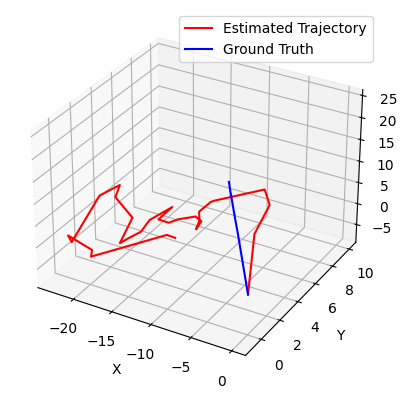

In [10]:
# Optional: Visualize the estimated trajectory and ground truth using Matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot estimated trajectory (in red) and ground truth (in blue)
ax.plot(trajectory[:, 0, 3], trajectory[:, 1, 3], trajectory[:, 2, 3], 'r', label='Estimated Trajectory')
ax.plot(ground_truth[:, 0, 3], ground_truth[:, 1, 3], ground_truth[:, 2, 3], 'b', label='Ground Truth')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.legend()
plt.show()